In [1]:
import psycopg2
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
#%matplotlib notebook
%matplotlib inline

In [25]:
conn = psycopg2.connect(database="centrotic", user="postgres",
                      password="raspberry", host="127.0.0.1",
                      port="5432")
cur = conn.cursor()

In [26]:
frec_central = [78000000,]
nfft = 1024
frec_muestreo = 16000000

query1 = "SELECT espectro FROM radioastronomia_espectro WHERE (frec_central = "+str(frec_central[0])+ "AND nfft="+str(nfft)+ " AND frec_muestreo="+str(frec_muestreo)+");"
#query2 = "SELECT espectro FROM radioastronomia_espectro WHERE (frec_central = "+str(frec_central[1])+ "AND nfft="+str(nfft)+ " AND frec_muestreo="+str(frec_muestreo)+");"
#query3 = "SELECT espectro FROM radioastronomia_espectro WHERE (frec_central = "+str(frec_central[2])+ "AND nfft="+str(nfft)+ " AND frec_muestreo="+str(frec_muestreo)+");"



In [27]:
cur.execute(query1)
rows1 = cur.fetchall()

In [28]:
def promedio(espectro, nfft):
    K = int(len(espectro)/(nfft))
    x = numpy.zeros(nfft)
    for i in range(K):
        x = x + espectro[i*nfft:(i+1)*nfft]
    x = x/K
    x = numpy.concatenate((x[int(nfft/2):], x[:int(nfft/2)]))

    return x

In [29]:
x1 = promedio(rows1[0][0], nfft)

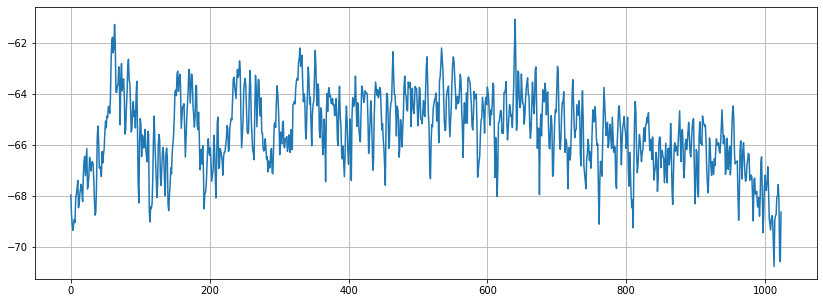

In [30]:
plt.figure(figsize=(14,5))
plt.plot(x1)
plt.grid(True)

# Analisis querys para barrido

## 1) extraccion de frecuencias centrales diferentes

In [31]:
cur.execute("SELECT DISTINCT frec_central FROM radioastronomia_espectro ORDER BY frec_central;")
rows = cur.fetchall()
frec_central = []
for row in rows:
    frec_central.append(row[0])

print(frec_central)

[78000000.0, 86000000.0, 94000000.0, 102000000.0, 110000000.0, 118000000.0, 126000000.0, 134000000.0, 142000000.0, 400000000.0, 408000000.0, 416000000.0, 1800000000.0]


## 2) extraccion del espectro por cada frecuencia central

In [32]:
y = numpy.array([])
freq = numpy.array([])

for frec_cen in frec_central:
    query = []
    query.append("SELECT espectro FROM radioastronomia_espectro ")
    query.append("WHERE (nfft = ")
    query.append(str(1024))
    query.append(" AND frec_muestreo = ")
    query.append(str(16000000))
    query.append(" AND frec_central = ")
    query.append(str(frec_cen))
    query.append(");")
    query = "".join(query)
            
    # extraccion del espectro
    cur.execute(query)
    rows = cur.fetchall()
    x_ = numpy.zeros(1024)
    for row in rows:
        espectro = row[0]
        espectro = numpy.asarray(espectro)
        x = promedio(espectro, 1024)
        x_ = x_ + x
    x_ = x_/len(rows)
    freq = numpy.append(freq, numpy.arange(-int(1024/2),int(1024/2),1)*16000000/(1024*2) + frec_cen)
    y = numpy.append(y,x_)

Text(0, 0.5, 'Espectro')

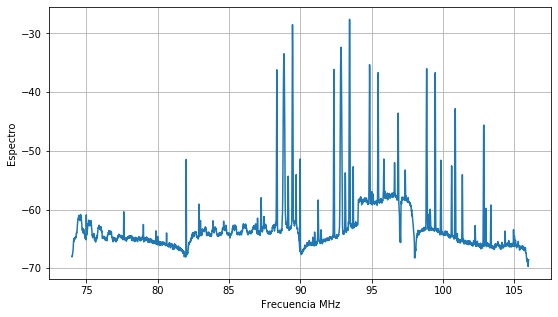

In [33]:
plt.figure(figsize=(9,5))
plt.plot(freq[:4096]/1000000, y[:4096])
plt.grid(True)
plt.xlabel("Frecuencia MHz")
plt.ylabel("Espectro")

### prueba individual de una banda

In [14]:
query = []
query.append("SELECT espectro FROM radioastronomia_espectro ")
query.append("WHERE (nfft = ")
query.append(str(1024))
query.append(" AND frec_muestreo = ")
query.append(str(16000000))
query.append(" AND frec_central = ")
query.append(str(86000000))
query.append(");")
query = "".join(query)
print(query)

SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 16000000 AND frec_central = 86000000);


In [15]:
cur.execute(query)
rows = cur.fetchall()
x_ = numpy.zeros(1024)
for row in rows:
    espectro = row[0]
    espectro = numpy.asarray(espectro)
    x = promedio(espectro, 1024)
    x_ = x_ + x
x_ = x_/len(rows)

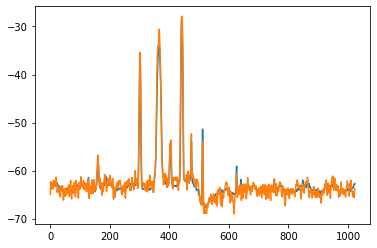

In [16]:
plt.figure()
plt.plot(x_)
plt.plot(x)

In [17]:
car_e = numpy.array([])
for f in frec_central:
    #extraccion de ids referentes a las muestras
    query = []
    query.append("SELECT id FROM radioastronomia_espectro WHERE (frec_central=")
    query.append(str(f))
    query.append(");")
    query = "".join(query)
    cur.execute(query)
    rows = cur.fetchall() #las filas que contienen los ids
    # extraccion del espectro respecto a los ids obtenidos
    a = []
    for i in rows:
        a.append(i[0])
    a = tuple(a)
    query =[]
    query.append("SELECT id, max_v, min_v, espectro_id, energia FROM radioastronomia_caracteristicasespectro WHERE espectro_id IN ")
    query.append(str(a))
    query.append(";")
    query = "".join(query)
    cur.execute(query)
    rows = cur.fetchall() #las filas que contienen los espectros
    
    mu = 0
    for row in rows:
        id = row[0]
        max_v = row[1]
        max_v = numpy.asarray(max_v)
        min_v = row[2]
        min_v = numpy.asarray(min_v)
        energia = row[4]
        energia = numpy.asarray(energia)
        mu = mu + numpy.mean(energia)
    mu = mu/len(rows)
    mu = 10*numpy.log10(mu)
    car_e= numpy.append(car_e, mu)

SyntaxError: syntax error at or near ")"
LINE 1: ...onomia_caracteristicasespectro WHERE espectro_id IN (8561,);
                                                                     ^


<BarContainer object of 86 artists>

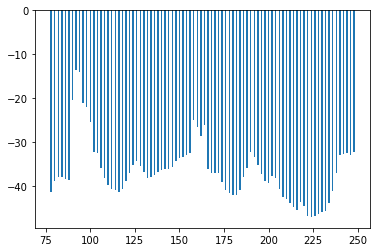

In [24]:
frec_central = numpy.asarray(frec_central)
plt.bar(frec_central/1e6, car_e)

In [24]:
conn.close()